<a href="https://colab.research.google.com/github/ReddySameer/tensorflow/blob/main/04_transferlearning_in_tensorflow_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue May 28 19:06:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-05-28 19:06:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  82.4MB/s    in 2.0s    

2024-05-28 19:06:45 (82.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"len of Dirnames: {len(dirnames)} and len of iamge filenames: {len(filenames)} in Directory '{dirpath}',")

len of Dirnames: 2 and len of iamge filenames: 0 in Directory '10_food_classes_10_percent',
len of Dirnames: 10 and len of iamge filenames: 0 in Directory '10_food_classes_10_percent/test',
len of Dirnames: 0 and len of iamge filenames: 250 in Directory '10_food_classes_10_percent/test/fried_rice',
len of Dirnames: 0 and len of iamge filenames: 250 in Directory '10_food_classes_10_percent/test/sushi',
len of Dirnames: 0 and len of iamge filenames: 250 in Directory '10_food_classes_10_percent/test/hamburger',
len of Dirnames: 0 and len of iamge filenames: 250 in Directory '10_food_classes_10_percent/test/chicken_wings',
len of Dirnames: 0 and len of iamge filenames: 250 in Directory '10_food_classes_10_percent/test/pizza',
len of Dirnames: 0 and len of iamge filenames: 250 in Directory '10_food_classes_10_percent/test/ice_cream',
len of Dirnames: 0 and len of iamge filenames: 250 in Directory '10_food_classes_10_percent/test/ramen',
len of Dirnames: 0 and len of iamge filenames: 250 in 

# Use  ImageDataGenerator to load images in batches

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
## Create Dataloaders
IMAGE_SHAPE = (224, 224)  # Hyperparameters (?)
BATCH_SIZE = 5  # Hyperparameters (?)

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

training images:
Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


## Callbacks
Callbacks are extra functionality on the models that can be performed during or after training, evaluation or inference.

* **TensorBoard** - to log performance of multiple models - track experiments
* **Model Checkpointing**  - save model as it trains, to enable stop/restart training from it left off
* **Early Stopping** - Stop training after an arbitrary amount of time and to stop training automatically when it ceases to improve


In [6]:
import tensorflow as tf

In [7]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorbaord_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to: {log_dir}")
  return tensorbaord_callback

# Access pretrained models from https://www.kaggle.com/models?tfhub-redirect=true

* https://www.kaggle.com/models/tensorflow/efficientnet


In [8]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
IMAGE_SHAPE, IMAGE_SHAPE+(3,)


((224, 224), (224, 224, 3))

In [11]:
# Create a model function from a URL
def create_model(model_url, num_classes=10):
  """
   Takes a TEnsorflow hub url and creates a keras sequential model with it.

   Args:
    model_url (str): A Tensorflow hub feature extraction url
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10

   Returns:
    An uncompiled Keras Sequential model with Model_url as feature extractor layer
    and Dense output layer with num_classes output neurons

  """

  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extraction_layer,
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

In [12]:
# create a Resnet Model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [13]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [14]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving tensorboard log files to: tensorflow_hub/resnet50V2/20240528-190728
Epoch 1/5
150/150 [==============================] - 22s 98ms/step - loss: 1.4311 - accuracy: 0.5387 - val_loss: 0.7898 - val_accuracy: 0.7408
Epoch 2/5
150/150 [==============================] - 12s 83ms/step - loss: 0.5485 - accuracy: 0.8320 - val_loss: 0.6819 - val_accuracy: 0.7716
Epoch 3/5
150/150 [==============================] - 13s 86ms/step - loss: 0.3313 - accuracy: 0.9227 - val_loss: 0.6545 - val_accuracy: 0.7840
Epoch 4/5
150/150 [==============================] - 14s 92ms/step - loss: 0.2140 - accuracy: 0.9600 - val_loss: 0.6312 - val_accuracy: 0.7916
Epoch 5/5
150/150 [==============================] - 13s 87ms/step - loss: 0.1431 - accuracy: 0.9853 - val_loss: 0.6556 - val_accuracy: 0.7796


In [15]:
# Function to create  model to plot the loss codes
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
    Returns separate loss curves for training and validation metrics.

    Args:
      history: TensorFlow History object

    Returns:
      Plots of training/validation loss and accuracy metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_accuracy"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


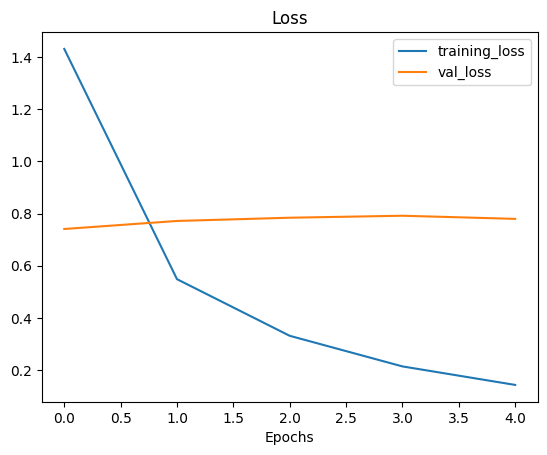

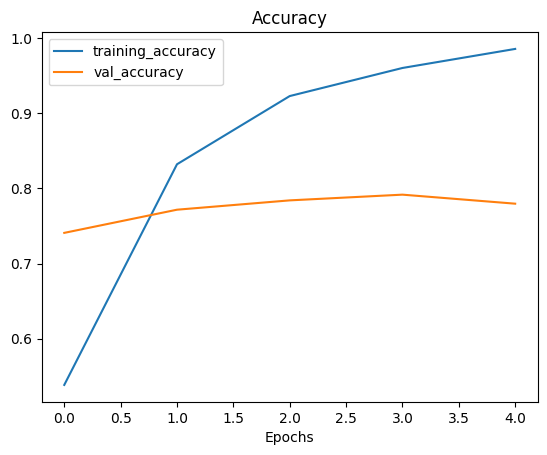

In [16]:
plot_loss_curves(resnet_history)

In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


# EfficientNetB0

In [18]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])
efficientnet_history= efficientnet_model.fit(train_data_10_percent,
                                             epochs=5,
                                             steps_per_epoch=len(train_data_10_percent),
                                             validation_data=test_data_10_percent,
                                             validation_steps=len(test_data_10_percent),
                                             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetb0"
                                                                                    )])


Saving tensorboard log files to: tensorflow_hub/efficientnetb0/20240528-190933
Epoch 1/5
150/150 [==============================] - 22s 80ms/step - loss: 1.2889 - accuracy: 0.6213 - val_loss: 0.7074 - val_accuracy: 0.8364
Epoch 2/5
150/150 [==============================] - 13s 86ms/step - loss: 0.5748 - accuracy: 0.8547 - val_loss: 0.5420 - val_accuracy: 0.8460
Epoch 3/5
150/150 [==============================] - 13s 85ms/step - loss: 0.4046 - accuracy: 0.9027 - val_loss: 0.4665 - val_accuracy: 0.8696
Epoch 4/5
150/150 [==============================] - 17s 112ms/step - loss: 0.3000 - accuracy: 0.9427 - val_loss: 0.4267 - val_accuracy: 0.8712
Epoch 5/5
150/150 [==============================] - 23s 156ms/step - loss: 0.2316 - accuracy: 0.9707 - val_loss: 0.4213 - val_accuracy: 0.8696


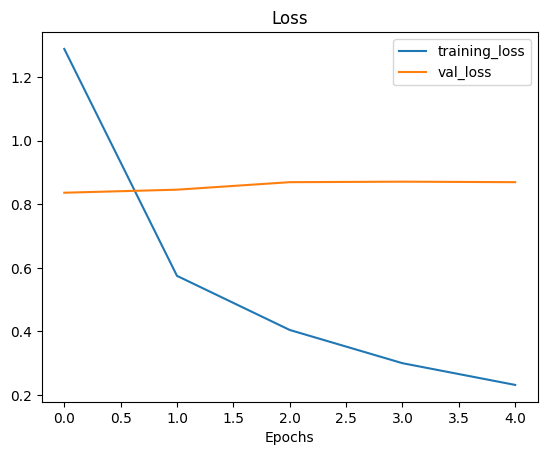

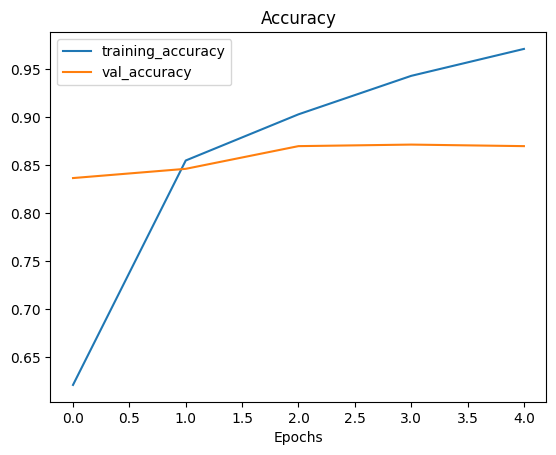

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
efficientnet_model.layers
efficientnet_model.layers[0]
efficientnet_model.layers[0].weights
len(efficientnet_model.layers[0].weights)

309

In [29]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2 vs Mobilenet-V2" \
  --description "Compares three different TF Hub Feature extraction model architecures using 10% of the training data" \
  --one_shot

2024-05-28 19:18:13.565332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 19:18:13.565390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 19:18:13.566804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 19:18:14.551796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [25]:
# Upload to tensor board
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2 vs Mobilenet-V2"
  --description "Compares three different TF Hub Feature extraction model architecures using 10% of the training data"
  --one_shot


IndentationError: unexpected indent (<ipython-input-25-4ae549f4573a>, line 3)

In [23]:
mobilenet_url="https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/1"

In [13]:
train_data_10_percent.num_classes

10

In [24]:
mobilenet_model = create_model(mobilenet_url, num_classes=train_data_10_percent.num_classes)

mobilenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=len(test_data_10_percent),
                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                           experiment_name="mobilenet-v2"
                                                          )])

Saving tensorboard log files to: tensorflow_hub/mobilenet-v2/20240528-191322
Epoch 1/5
150/150 [==============================] - 15s 72ms/step - loss: 1.5365 - accuracy: 0.5013 - val_loss: 0.7969 - val_accuracy: 0.7456
Epoch 2/5
150/150 [==============================] - 13s 85ms/step - loss: 0.6326 - accuracy: 0.8080 - val_loss: 0.6415 - val_accuracy: 0.7976
Epoch 3/5
150/150 [==============================] - 13s 84ms/step - loss: 0.4009 - accuracy: 0.8947 - val_loss: 0.6060 - val_accuracy: 0.7988
Epoch 4/5
150/150 [==============================] - 14s 91ms/step - loss: 0.2876 - accuracy: 0.9373 - val_loss: 0.5649 - val_accuracy: 0.8140
Epoch 5/5
150/150 [==============================] - 13s 85ms/step - loss: 0.2028 - accuracy: 0.9733 - val_loss: 0.5510 - val_accuracy: 0.8184


In [ ]:
plot_loss_curves(mobilenet_history)